In [1]:
###################################
# disable tf deprecation warnings #
###################################
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from BPutils import *
import logging
import pickle
import joblib
import json
tf.get_logger().setLevel(logging.ERROR)


################
## SETUP MODEL #
################
__BATCH_SIZE = 38#48
__IN_DIM = 224
__EPOCHS = 15
__WEIGHTED_LOSS = True
__USE__CLASSWEIGHTS = True

2024-04-09 20:08:54.149147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 20:08:54.149218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 20:08:54.318342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


SET UP: the datasets and anotations names

In [3]:
affectnet_trainset = False

if affectnet_trainset:
    validation_set_fp = "annotations_splits/validation_affectnet_nir.csv"
    train_set_fp = "annotations_splits/train_affectnet_nir.csv"
    filepath_colun_name = 'subDirectory_filePath'
    train_datafolder_fp = '../data_folder/AffectNet-NIR/train_set/'
    data_name = "affectnet_nir"
else:
    validation_set_fp = "annotations_splits/df_fer_val.csv"
    train_set_fp = "annotations_splits/df_fer_train.csv"
    filepath_colun_name = 'adjusted_unique_filename'
    train_datafolder_fp = '../data_folder/combined_fer/'
    data_name = "combined_fer" # Combined FER is BUAA+OuluCasia+CustomDB

Define functions

In [4]:
def get_train_val_data():
    if affectnet_trainset:
        # load data
        training_data = pd.read_csv(train_set_fp)
        # remove no face
        training_data = training_data[training_data['valence'] != -2]
        # remove TIF
        training_data['FileType'] = training_data[filepath_colun_name].apply(lambda x: x.split('.')[-1])
        # remove "none" emotion class
        training_data = training_data[training_data.expression != 8]
        training_data.replace({'expression':e_dict_8}, inplace=True)

        ########

        # Create validation split from trainning data
        # Shuffle the data
        training_data = training_data.sample(frac=1, random_state=42)

        num_of_val_split_images = 10000

        # Split off the validation data
        validation_data = training_data[:num_of_val_split_images]

        # Keep the rest in the training data
        training_data = training_data[num_of_val_split_images:]

        ########
    else:
         # load data
        training_data = pd.read_csv(train_set_fp)
        validation_data = pd.read_csv(validation_set_fp)
        
        training_data.rename(columns={"expression": "expression_id"}, inplace=True)
        training_data.rename(columns={"expression_name": "expression"}, inplace=True)
        validation_data.rename(columns={"expression": "expression_id"}, inplace=True)
        validation_data.rename(columns={"expression_name": "expression"}, inplace=True)
        
        # remove no face
#         training_data = training_data[training_data['valence'] != -2]
#         # remove TIF
#         training_data['FileType'] = training_data[filepath_colun_name].apply(lambda x: x.split('.')[-1])
#         # remove "none" emotion class
#         training_data = training_data[training_data.expression != 8]
#         training_data.replace({'expression':e_dict_8}, inplace=True)

    
    return training_data, validation_data
    
    
def drop_nonexisting_data(training_data, validation_data):
    # Assuming training_data is your DataFrame
    non_existent_files = []

    for index, row in training_data.iterrows():
        file_path = train_datafolder_fp + row[filepath_colun_name]
        if not os.path.isfile(file_path):
            non_existent_files.append(index)

    # Remove non-existent files from DataFrame
    training_data = training_data.drop(non_existent_files)

    print("Dropped train files:", len(non_existent_files), "|", "remained train set:", len(training_data.index))
    ########

    # Assuming validation_data is your DataFrame
    non_existent_files = []

    for index, row in validation_data.iterrows():
        file_path = train_datafolder_fp + row[filepath_colun_name]
        if not os.path.isfile(file_path):
            non_existent_files.append(index)

    # Remove non-existent files from DataFrame
    validation_data = validation_data.drop(non_existent_files)
    print("Dropped val files:", len(non_existent_files), "|", "remained val set:", len(validation_data.index))
    
    return training_data, validation_data


def apply_weights(training_data):
    if(__USE__CLASSWEIGHTS):
        #########################################
        # ASSIGN TRAINING SAMPLES CLASS WEIGTHS #
        #########################################
        weights_dict = training_data.expression.value_counts().sort_index().to_dict()
        total_samples = len(training_data.expression)
        weights = [ ( total_samples / (len(training_data.expression.value_counts().sort_index().values) \
                * class_samples)) for class_samples in training_data.expression.value_counts().sort_index().values]
        #display(weights)
        j = 0
        for i in weights_dict:
            weights_dict[i]=weights[j]
            j += 1

        training_data["weight"]=training_data["expression"]#.map(e_dict)
        #display(training_data.head(25))
        training_data.replace({'weight':weights_dict},inplace=True)
    else:
        ################################
        ## APPLY WEIGTHS BY n*n BOXES ##
        ################################
        _num_boxes = 7
        ####################
        t = np.linspace(-1,1,_num_boxes+1)
        _dict = {}
        # iterate over intervals in 2d
        for val_int in [(x,y) for x,y in zip(t[:-1], t[1:])]:
            inner_acc = []
            for aro_int in [(x,y) for x,y in zip(t[:-1], t[1:])]:
                tmp = \
                training_data[ (training_data.valence >= val_int[0]) & (training_data.valence <= val_int[1]) \
                            & (training_data.arousal >= aro_int[0]) & (training_data.arousal <= aro_int[1]) ]
                if( len(tmp.index) != 0 ):
                    box_weight = (len(training_data.valence)/((_num_boxes**2 \
                                    -(_num_boxes**2 * 0.2146 )) * len(tmp.valence)))

                    for j in tmp.index:
                        _dict[j]=box_weight

        training_data['weight']=training_data.index.map(_dict)
        
    return training_data


def create_dummies(training_data, validation_data):
    print("Before dummies")
    display(training_data.head(1))
    training_data = pd.get_dummies(training_data, columns=["expression"],)
    validation_data = pd.get_dummies(validation_data, columns=["expression"])
    print("After dummies")
    display(training_data.head(1))
    
    # convert expression values to float64
    # List of columns to convert
    cols_to_convert = ['expression_Anger', 'expression_Contempt', 'expression_Disgust', 'expression_Fear', 
                       'expression_Happy', 'expression_Neutral', 'expression_Sad', 'expression_Surprise']

    # Convert each column to float64 - training data
    for col in cols_to_convert:
        training_data[col] = training_data[col].astype('float64')
    # Convert each column to float64 - validation data
    for col in cols_to_convert:
        validation_data[col] = validation_data[col].astype('float64')
        
    return training_data, validation_data

def get_data_generators(training_data, validation_data):
    datagen=ImageDataGenerator(
        rescale=2./255.,
        samplewise_center = True,
        brightness_range=(0.9,1.1),
        zoom_range=[0.8,1],
        rotation_range=10,
        horizontal_flip=True)
    val_datagen=ImageDataGenerator(
        rescale=2./255.,
        samplewise_center = True
    )
    
    ###############################
    #  For continuous VA model    #
    ###############################
    train_generator=datagen.flow_from_dataframe(
    dataframe=training_data,
    directory=train_datafolder_fp,
    x_col=filepath_colun_name,
    y_col=['valence', 'arousal','expression_Neutral', 'expression_Happy', 'expression_Sad', \
            'expression_Surprise', 'expression_Fear', 'expression_Disgust', \
            'expression_Anger', 'expression_Contempt'],#
    #color_mode= "grayscale",
    batch_size=__BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="raw",
    weight_col='weight' if __WEIGHTED_LOSS else None,
    validate_filenames=False,
    target_size=(__IN_DIM,__IN_DIM))

    valid_generator=val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory=train_datafolder_fp,
    x_col=filepath_colun_name,
    y_col=['valence', 'arousal','expression_Neutral', 'expression_Happy', 'expression_Sad', \
            'expression_Surprise', 'expression_Fear', 'expression_Disgust', \
            'expression_Anger', 'expression_Contempt'],#
    #color_mode= "grayscale",
    batch_size=__BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="raw",
    validate_filenames=False,
    target_size=(__IN_DIM,__IN_DIM))
    
    return train_generator, valid_generator

def showbatch(train_generator):
    sample_batch = train_generator.next()
    i=0
    fig = plt.figure(figsize=(12,12))
    for img_batch in sample_batch:
        for img in img_batch:
            plt.subplot(int(__BATCH_SIZE**(1/2))+1,int(__BATCH_SIZE**(1/2))+1,0 + 1 + i)
            plt.imshow(img)
            i=i+1    
        if i >= __BATCH_SIZE:
            break
            
########################
# CUSTOM LOSS FUNCTION #
########################

@tf.function
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss (w/o the L2 norm, this works better)
    """
    return 2*K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

@tf.function
def sig_reg_cross_entropy(y_true, y_pred):
    """
    Cross entropy regression loss from paper 'Simultaneous Prediction of Valence/Arousal and Emotions on
    AffectNet, Aff-Wild and AFEW-VA'
    """
    return -( 0.5 * (y_true + 1) ) * K.log(y_pred) - ((1 - ( 0.5 * (y_true + 1) )) * K.log(1 - y_pred))

RUN THE SCRIPT
***
fetch and prepare data

In [5]:
#########################
###### PREPARE DATA #####
#########################

# FETCH DATA
training_data, validation_data = get_train_val_data()

training_data["_expression"] = training_data["expression"]
validation_data["_expression"] = validation_data["expression"]

# DROP NONEXISTING FILES
training_data, validation_data = drop_nonexisting_data(training_data, validation_data)

# APPLY WEIGHTS
training_data = apply_weights(training_data)
display(training_data.head(5))
display(training_data.weight.value_counts())

# CREATE DUMMIES
training_data, validation_data = create_dummies(training_data, validation_data)

# GET GENERATORS
train_generator, valid_generator = get_data_generators(training_data, validation_data)

# This visualizes the augmented batch, fails for some batchsizes tho
# showbatch(train_generator)

Dropped train files: 0 | remained train set: 1742
Dropped val files: 0 | remained val set: 360


,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,...,valence,arousal,expression,buaa-patient,buaa-image_type,customdb-patient,new_filetype,split,_expression,weight
0,0,0,data/BUAA/BUAAVISNIR/19/2.bmp,1,buaa,nir,2.bmp,buaa-19-2.jpg,NaN,NaN,...,0.00,0.00,Neutral,19.0,neutral,NaN,jpg,train,Neutral,0.444388
1,1,1,data/BUAA/BUAAVISNIR/19/22.bmp,19,buaa,nir,22.bmp,buaa-19-22.jpg,NaN,NaN,...,0.37,0.09,Happy,19.0,affection,NaN,jpg,train,Happy,0.766725
2,2,2,data/BUAA/BUAAVISNIR/19/24.bmp,21,buaa,nir,24.bmp,buaa-19-24.jpg,NaN,NaN,...,-0.42,0.74,Anger,19.0,affection,NaN,jpg,train,Anger,1.189891
3,3,3,data/BUAA/BUAAVISNIR/19/26.bmp,23,buaa,nir,26.bmp,buaa-19-26.jpg,NaN,NaN,...,-0.84,-0.47,Sad,19.0,affection,NaN,jpg,train,Sad,0.989773
4,4,4,data/BUAA/BUAAVISNIR/19/28.bmp,25,buaa,nir,28.bmp,buaa-19-28.jpg,NaN,NaN,...,-0.16,0.76,Fear,19.0,affection,NaN,jpg,train,Fear,1.134115


weight
0.444388    490
0.766725    284
0.989773    220
1.134115    192
1.189891    183
1.258671    173
1.352484    161
5.583333     39
Name: count, dtype: int64

Before dummies


,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,...,valence,arousal,expression,buaa-patient,buaa-image_type,customdb-patient,new_filetype,split,_expression,weight
0,0,0,data/BUAA/BUAAVISNIR/19/2.bmp,1,buaa,nir,2.bmp,buaa-19-2.jpg,NaN,NaN,...,0.0,0.0,Neutral,19.0,neutral,NaN,jpg,train,Neutral,0.444388


After dummies


,Unnamed: 0.2,Unnamed: 0.1,filepath,Unnamed: 0,db,spectra,filename,adjusted_unique_filename,oulucasia-patient,oulucasia-emotion,...,_expression,weight,expression_Anger,expression_Contempt,expression_Disgust,expression_Fear,expression_Happy,expression_Neutral,expression_Sad,expression_Surprise
0,0,0,data/BUAA/BUAAVISNIR/19/2.bmp,1,buaa,nir,2.bmp,buaa-19-2.jpg,NaN,NaN,...,Neutral,0.444388,False,False,False,False,False,True,False,False


Found 1742 non-validated image filenames.
Found 360 non-validated image filenames.


SET UP PRETRAINING!

In [7]:
#########################
# LOAD PRETRAINED MODEL #
#########################

# which model to pretrain
fileName = "mobilenet_on_aff" # those are theoriginal weights of model trained on VIS AffectNet
# Applies when 'fileName == "mobilenet_on_aff"' -> when it is pretraining the original
architecture_name = 'mobilenet_combined'


# load json and create model
model = tf.keras.models.model_from_json( open( ("models/fer/%s.json"%fileName) , 'r') . read() )
# load weights into new model
model.load_weights(("models/fer/%s_CHECKPOINT.hdf5"%fileName))

# freeze all layers except the last n-layers
for layer in model.layers[:-16]:
    layer.trainable = False

# set up learninign rate
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(8e-5,
                                                        decay_steps=train_generator.n//train_generator.batch_size,
                                                        decay_rate=0.85,
                                                        staircase=True)

model.compile(optimizers.Adam(learning_rate=learning_rate),loss=sig_reg_cross_entropy,metrics=["mse", "mae", tf.keras.metrics.RootMeanSquaredError()])


fileName = architecture_name if fileName == 'mobilenet_on_aff' else fileName + "_continue"

In [8]:
# serialize model to JSON
model_json = model.to_json()
with open("models/fer/%s.json"%fileName, "w") as json_file:
    json_file.write(model_json)

In [9]:
# Save last set of weights with the best val loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=("models/fer/"+fileName+"_CHECKPOINT.hdf5"), monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

# Stop training if val loss doesn't improve for set number of epochs
model_earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

# Model training, the hybrid generator is a custom class that re-formats the data before they can be processed
# with a simultaneous predictor network
history = model.fit_generator(generator=hybrid_generator(train_generator, STEP_SIZE_TRAIN, returnWeights=__WEIGHTED_LOSS),
                    #use_multiprocessing=True, # This causes random deadlocks
                    workers=8, # Number of CPU threads to use
                    verbose=1,
                    use_multiprocessing=False,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=hybrid_generator(valid_generator,STEP_SIZE_VALID, returnWeights = False),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=__EPOCHS,
                    callbacks=[model_checkpoint_callback,
                               model_earlystop_callback,
#                                tensorboard
                    ]
)

with open('models/fer/'+ fileName +'-loss_history.json', 'w') as file_pi:
    json.dump(history.history, file_pi, indent=4)

Epoch 1/15
45/45 [==============================] - 62s 1s/step - loss: 2.3928 - classifier_loss: 1.7738 - regressor_loss: 0.6190 - classifier_mse: 0.0889 - classifier_mae: 0.1662 - classifier_root_mean_squared_error: 0.2982 - regressor_mse: 0.3684 - regressor_mae: 0.5066 - regressor_root_mean_squared_error: 0.6070 - val_loss: 2.1798 - val_classifier_loss: 1.5290 - val_regressor_loss: 0.6508 - val_classifier_mse: 0.0835 - val_classifier_mae: 0.1713 - val_classifier_root_mean_squared_error: 0.2890 - val_regressor_mse: 0.3189 - val_regressor_mae: 0.4661 - val_regressor_root_mean_squared_error: 0.5647
Epoch 2/15
45/45 [==============================] - 55s 1s/step - loss: 2.1091 - classifier_loss: 1.4854 - regressor_loss: 0.6238 - classifier_mse: 0.0896 - classifier_mae: 0.1804 - classifier_root_mean_squared_error: 0.2994 - regressor_mse: 0.3919 - regressor_mae: 0.5252 - regressor_root_mean_squared_error: 0.6260 - val_loss: 2.0547 - val_classifier_loss: 1.3997 - val_regressor_loss: 0.6550

45/45 [==============================] - 53s 1s/step - loss: 1.9096 - classifier_loss: 1.2746 - regressor_loss: 0.6350 - classifier_mse: 0.0979 - classifier_mae: 0.2041 - classifier_root_mean_squared_error: 0.3129 - regressor_mse: 0.3809 - regressor_mae: 0.5146 - regressor_root_mean_squared_error: 0.6172 - val_loss: 1.9014 - val_classifier_loss: 1.2554 - val_regressor_loss: 0.6460 - val_classifier_mse: 0.0945 - val_classifier_mae: 0.2001 - val_classifier_root_mean_squared_error: 0.3074 - val_regressor_mse: 0.3829 - val_regressor_mae: 0.5169 - val_regressor_root_mean_squared_error: 0.6188
Epoch 15/15
45/45 [==============================] - 53s 1s/step - loss: 1.9160 - classifier_loss: 1.2812 - regressor_loss: 0.6348 - classifier_mse: 0.0980 - classifier_mae: 0.2041 - classifier_root_mean_squared_error: 0.3131 - regressor_mse: 0.3858 - regressor_mae: 0.5172 - regressor_root_mean_squared_error: 0.6211 - val_loss: 1.9060 - val_classifier_loss: 1.2586 - val_regressor_loss: 0.6474 - val_cla

In [11]:
model.evaluate(hybrid_generator(valid_generator,STEP_SIZE_VALID, returnWeights=False),
steps=STEP_SIZE_VALID)

9/9 [==============================] - 2s 183ms/step - loss: 1.9058 - classifier_loss: 1.2571 - regressor_loss: 0.6487 - classifier_mse: 0.0939 - classifier_mae: 0.1992 - classifier_root_mean_squared_error: 0.3064 - regressor_mse: 0.3802 - regressor_mae: 0.5092 - regressor_root_mean_squared_error: 0.6166


[1.9058111906051636,
 1.2570781707763672,
 0.6487332582473755,
 0.09387008100748062,
 0.19922903180122375,
 0.3063822388648987,
 0.3801737427711487,
 0.5091950297355652,
 0.6165823340415955]

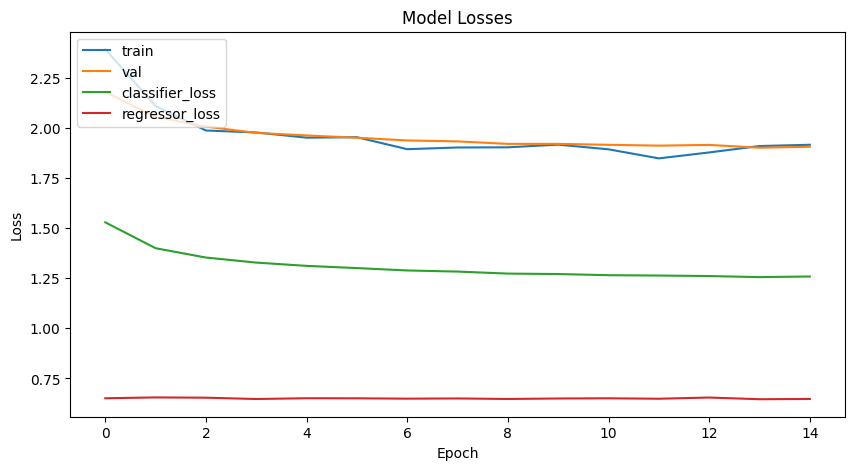

In [12]:
#############################
# Plot the training history #
#############################
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_classifier_loss'])
plt.plot(history.history['val_regressor_loss'])
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'classifier_loss', 'regressor_loss'], loc='upper left')
plt.show()
fig.savefig(str(fileName+'.png'),dpi=500,format='png')

In [13]:
########################################
# Export the trained model and weigths #
########################################
# serialize model to JSON
model_json = model.to_json()
with open("%s.json"%fileName, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/fer/%s.h5"%fileName)
print("Saved model to disk")

Saved model to disk


## MODEL TUNING WITH OPTUNA

In [11]:
###################################
# disable tf deprecation warnings #
###################################
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from time import time
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from BPutils import *
import logging
tf.get_logger().setLevel(logging.ERROR)

################
#### SET UP ####
################
__BATCH_SIZE = 48
__IN_DIM = 224
__EPOCHS = 12#15
__WEIGHTED_LOSS = True
__USE__CLASSWEIGHTS = True

2024-02-09 11:31:25.885918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 11:31:25.885994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 11:31:26.025511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[]
model_mobilenet_1_hybrid_rgb_12ep_classweight_lr2396-001085_entropy


In [113]:
import optuna

from tensorflow.keras.backend import clear_session
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
# import tensorflow_datasets as tfds

import tensorflow as tf
import gc



def get_generators(trial):
    __BATCH_SIZE = trial.suggest_int("batch_size", 32, 128, log=True)
    
    # FETCH DATA
    training_data, validation_data = get_train_val_data()

    # DROP NONEXISTING FILES
    training_data, validation_data = drop_nonexisting_data(training_data, validation_data)

    # APPLY WEIGHTS
    training_data = apply_weights(training_data)
    display(training_data.head(5))
    display(training_data.weight.value_counts())

    # CREATE DUMMIES
    training_data, validation_data = create_dummies(training_data, validation_data)

    # GET GENERATORS
    train_generator, valid_generator = get_data_generators(training_data, validation_data)

    return train_generator, valid_generator

def create_model(trial, train_generator):
    # which model to pretrain - original model on vis affectnet
    fileName = "mobilenet_on_aff"
    
    model = tf.keras.models.model_from_json( open( ("models/fer/%s.json"%fileName) , 'r') . read() )
    model.load_weights(("models/fer/%s_CHECKPOINT.hdf5"%fileName))

    # freeze all layers except the last 4
    tunable_num_freeze_layers = trial.suggest_categorical("num_freeze_layers", [-1, -2, -3, -4, -5, -6, -7, -8])
    for layer in model.layers[:tunable_num_freeze_layers]:
        layer.trainable = False

    # set up learninign rate
#     learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(2e-4,
#                                                             decay_steps=train_generator.n//train_generator.batch_size,
#                                                             decay_rate=0.85,
#                                                             staircase=True)
    tunable_learning_rate = trial.suggest_float("learning_rate", 5e-5, 2e-3, log=True)
    model.compile(optimizers.Adam(learning_rate=tunable_learning_rate),loss=sig_reg_cross_entropy,metrics=["mse", "mae", tf.keras.metrics.RootMeanSquaredError()])

    return model

def objective(trial):
    # Clear clutter from previous tf.keras session graphs.
    gc.collect()
    clear_session()

    # Create generator instances
    train_generator, valid_generator = get_generators(trial)

    # set up model
    model = create_model(trial, train_generator)

    # model.summary()

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

    # DEFINE CALLBACKS
    # Stop training if val loss doesn't improve for set number of epochs
    model_earlystop_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=1,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False
    )

    model_prunning_callback = TFKerasPruningCallback(trial, 'val_loss')

    # Model training, the hybrid generator is a custom class that re-formats the data before they can be processed
    # with a simultaneous predictor network
    history = model.fit_generator(generator=hybrid_generator(train_generator, STEP_SIZE_TRAIN, returnWeights=__WEIGHTED_LOSS),
                        #use_multiprocessing=True, # This causes random deadlocks
                        workers=8, # Number of CPU threads to use
                        verbose=1,
                        use_multiprocessing=False,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=hybrid_generator(valid_generator,STEP_SIZE_VALID, returnWeights = False),
                        validation_steps=STEP_SIZE_VALID,
                        epochs=__EPOCHS,
                        callbacks=[model_earlystop_callback,model_prunning_callback]
    )

    return history.history["val_loss"][-1]

def show_result(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


prepare study

In [ ]:
# Prepare study
study_fn = 'optuna_studies/' + 'mobilenet_study-pretrained_on-' + data_name + '.pkl'

if not os.path.exists(study_fn):
    study = optuna.create_study(
        direction="minimize", pruner=optuna.pruners.MedianPruner(n_startup_trials=2)
    )
else:
    study = joblib.load(study_fn)

run optimization study

In [115]:
study.optimize(objective, n_trials=100, timeout=50000, gc_after_trial=True)

show_result(study)

Dropped train files: 23480 | remained train set: 196586
Dropped val files: 1044 | remained val set: 8956


,Unnamed: 0,subDirectory_filePath,expression,valence,arousal,FileType,weight
217670,217670,414775.jpg,Sad,-0.612849,-0.295858,jpg,1.415265
134906,134906,83900.jpg,Happy,0.785024,0.146653,jpg,0.267607
224641,224641,106956.jpg,Happy,0.573671,-0.069013,jpg,0.267607
256147,256147,303700.jpg,Anger,-0.404762,0.849206,jpg,1.435773
183459,183459,239905.jpg,Happy,0.753968,0.190476,jpg,0.267607


weight
0.267607    91826
0.479160    51284
1.415265    17363
1.435773    17115
2.592662     9478
5.702773     4309
9.343441     2630
9.520825     2581
Name: count, dtype: int64

Found 196586 non-validated image filenames.
Found 8956 non-validated image filenames.
Epoch 1/15
  14/5173 [..............................] - ETA: 1:47:16 - loss: 2.5415 - classifier_loss: 1.9380 - regressor_loss: 0.6035 - classifier_mse: 0.0683 - classifier_mae: 0.1317 - classifier_root_mean_squared_error: 0.2613 - regressor_mse: 0.3000 - regressor_mae: 0.4666 - regressor_root_mean_squared_error: 0.5477

[W 2024-03-10 23:26:10,118] Trial 9 failed with parameters: {'batch_size': 93, 'num_freeze_layers': -8, 'learning_rate': 7.837318933867544e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/student/DIP/mobilenet/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_331560/3874250978.py", line 211, in objective
    history = model.fit_generator(generator=hybrid_generator(train_generator, STEP_SIZE_TRAIN, returnWeights=__WEIGHTED_LOSS),
  File "/home/student/DIP/mobilenet/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator
    return self.fit(
  File "/home/student/DIP/mobilenet/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/home/student/DIP/mobilenet/venv/lib/python3.10/site-packages/keras/src/engine/training.py", l

KeyboardInterrupt: 

Save the study for later usage

In [64]:
joblib.dump(study, study_fn)  # Save the study to a file

# Later, you can load the study
# study = joblib.load(fn)

['study_mobilenet.pkl']

Explore the study

In [14]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_learning_rate,params_num_freeze_layers,state
0,0,2.758022,2024-02-07 13:13:25.971472,2024-02-07 15:14:40.428007,0 days 02:01:14.456535,87,0.000867,-1,COMPLETE
1,1,1.877460,2024-02-07 15:14:40.749899,2024-02-07 16:42:50.005884,0 days 01:28:09.255985,40,0.000877,-5,COMPLETE
2,2,1.871959,2024-02-07 19:29:59.945091,2024-02-07 22:30:56.240168,0 days 03:00:56.295077,85,0.000058,-4,COMPLETE
3,3,1.875323,2024-02-07 23:16:33.250887,2024-02-08 00:16:18.595520,0 days 00:59:45.344633,70,0.000226,-5,PRUNED
4,4,1.880165,2024-02-08 00:16:18.965400,2024-02-08 11:34:51.255386,0 days 11:18:32.289986,117,0.000222,-8,COMPLETE
5,5,1.867172,2024-02-08 11:56:38.896183,2024-02-08 19:08:06.190000,0 days 07:11:27.293817,38,0.000088,-8,COMPLETE
6,6,1.868273,2024-02-08 19:08:06.685304,2024-02-09 00:29:59.168094,0 days 05:21:52.482790,41,0.000126,-7,COMPLETE
7,7,1.874710,2024-02-09 00:29:59.689590,2024-02-09 01:27:37.558922,0 days 00:57:37.869332,38,0.000843,-2,PRUNED
8,8,1.875170,2024-02-09 01:27:38.103197,2024-02-09 02:26:40.998922,0 days 00:59:02.895725,59,0.000092,-4,PRUNED
9,9,1.874458,2024-02-09 11:31:30.692023,2024-02-09 15:12:50.482458,0 days 03:41:19.790435,93,0.000078,-8,PRUNED


In [15]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline
import plotly

In [16]:
plot_optimization_history(study)

In [17]:
plot_intermediate_values(study)

In [19]:
plot_parallel_coordinate(study)

In [20]:
plot_contour(study)

In [21]:
plot_param_importances(study)